In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
# 1. Load the dataset
df = pd.read_csv('/kaggle/input/delhi-air/delhi_aqi.csv', parse_dates=True)
df

,date,co,no,no2,o3,so2,pm2_5,pm10,nh3
0,2020-11-25 01:00:00,2616.88,2.18,70.60,13.59,38.62,364.61,411.73,28.63
1,2020-11-25 02:00:00,3631.59,23.25,89.11,0.33,54.36,420.96,486.21,41.04
2,2020-11-25 03:00:00,4539.49,52.75,100.08,1.11,68.67,463.68,541.95,49.14
3,2020-11-25 04:00:00,4539.49,50.96,111.04,6.44,78.20,454.81,534.00,48.13
4,2020-11-25 05:00:00,4379.27,42.92,117.90,17.17,87.74,448.14,529.19,46.61
...,...,...,...,...,...,...,...,...,...
18771,2023-01-24 04:00:00,1762.39,4.64,37.01,33.26,30.52,231.15,289.84,6.27
18772,2023-01-24 05:00:00,1735.69,6.82,34.96,46.49,34.33,225.08,280.52,9.12
18773,2023-01-24 06:00:00,1922.61,8.16,40.10,56.51,43.39,242.49,296.07,12.54
18774,2023-01-24 07:00:00,1361.85,9.05,52.78,71.53,100.14,165.67,191.82,7.47


In [3]:
# If there's a date column, convert to datetime and sort
if 'date' in df.columns:
    df['date'] = pd.to_datetime(df['date'])
    df.sort_values('date', inplace=True)

# Drop rows with missing PM2.5 values
df.dropna(subset=['pm2_5'], inplace=True)

In [4]:
# 2. Select features
#    - We'll include all numeric columns except 'pm2_5' as features.
feature_cols = df.select_dtypes(include=[np.number]).columns.drop('pm2_5')
# Create a new DataFrame with these features plus the target column
data = df[feature_cols.tolist() + ['pm2_5']].copy()

In [5]:
# 3. Scale the data to [0, 1]
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

In [6]:
# 4. Create sequences using a sliding window
#    window_size defines how many past timesteps to use for predicting the next value.
def create_sequences(dataset, target_index, window_size=10):
    X, y = [], []
    for i in range(len(dataset) - window_size):
        # Sequence of features for the past 'window_size' timesteps
        seq_x = dataset[i:i+window_size, :]
        # Target is the PM2.5 value at the next timestep
        seq_y = dataset[i+window_size, target_index]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

# Identify the index of 'pm2_5' within our scaled_data array
target_index = data.columns.get_loc('pm2_5')

# You can adjust the window size to see if it improves performance
window_size = 10
X, y = create_sequences(scaled_data, target_index, window_size=window_size)

# Check the shape of X and y
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

Shape of X: (18766, 10, 8)
Shape of y: (18766,)


In [7]:
# 5. Train-test split (80% training, 20% testing)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [8]:
# 6. Build the LSTM model
model = Sequential()
model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))  # (window_size, number_of_features)
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32))
model.add(Dropout(0.2))
model.add(Dense(1))  # Single output for PM2.5

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 10, 64)              │          18,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 10, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,137 (121.63 KB)

 Trainable params: 31,137 (121.63 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# 7. Early Stopping to avoid overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [10]:
# 8. Train the model
history = model.fit(
    X_train, y_train,
    epochs=50,              # Increase or decrease epochs to see if performance improves
    batch_size=32,          # You can also try different batch sizes
    validation_split=0.1,   # 10% of training data used for validation
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/50
423/423 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 0.0073 - val_loss: 7.4526e-04
Epoch 2/50
423/423 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0025 - val_loss: 7.1139e-04
Epoch 3/50
423/423 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0021 - val_loss: 5.5709e-04
Epoch 4/50
423/423 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0018 - val_loss: 5.5957e-04
Epoch 5/50
423/423 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0018 - val_loss: 4.7560e-04
Epoch 6/50
423/423 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0016 - val_loss: 4.5105e-04
Epoch 7/50
423/423 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0016 - val_loss: 3.4348e-04
Epoch 8/50
423/423 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0015 - val_loss: 3.5323e-04
Epoch 9/50
423/423 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0013 - val_loss: 3.4687e-04
Epoch 10/50
423/423 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0014 - val_loss: 3.9919e-04
Epoch 11/50
423/423 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0014 - val_loss: 3.3521e-04
Epoch 1

In [11]:
# 9. Make predictions
y_pred = model.predict(X_test)

118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


In [12]:
# 10. Evaluate model performance
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Test MSE:", mse)
print("Test MAE:", mae)
print("Test R2 Score:", r2)

Test MSE: 0.0004934128269829931
Test MAE: 0.013052401680819227
Test R2 Score: 0.9725739616370024


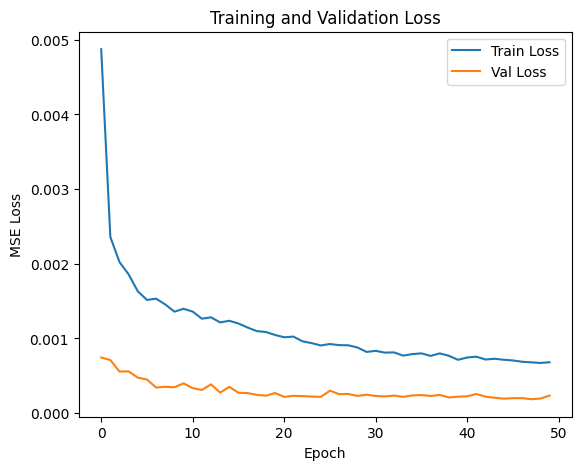

In [13]:
# 11. Plot training/validation loss and compare actual vs. predicted
plt.figure(figsize=(14, 5))

# Plot the training and validation loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()

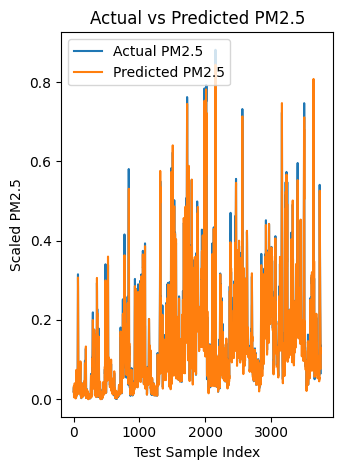

In [14]:
# Plot actual vs predicted on the test set
plt.subplot(1, 2, 2)
plt.plot(y_test, label='Actual PM2.5')
plt.plot(y_pred, label='Predicted PM2.5')
plt.title('Actual vs Predicted PM2.5')
plt.xlabel('Test Sample Index')
plt.ylabel('Scaled PM2.5')
plt.legend()

plt.tight_layout()
plt.show()